# Techniques of detection of manipulations in images 

In [ ]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
from preprocess import *
from model import *
from utils import *
import random
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns


np.random.seed(2)
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, MaxPooling2D, UpSampling2D, Input, Concatenate, Conv2DTranspose, BatchNormalization,Reshape
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


from PIL import Image, ImageChops, ImageEnhance,ImageFilter, ImageOps
from io import BytesIO
import cv2
from scipy.fftpack import dct
from scipy import ndimage
from scipy import fftpack
import optuna

## Heatmap detection using the convolutional layer

In [ ]:
def map_image(img_path,mascara):
    img = cv2.imread(img_path)

    # Dilatar las zonas detectadas para unirlas en áreas continuas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))

    dilated = cv2.dilate(mascara, kernel, iterations=15)
    
    # Calcular la distancia Euclidiana de cada píxel al contorno más cercano
    dist_transform = cv2.distanceTransform(dilated, cv2.DIST_L2, 3)
    dist_transform_norm = cv2.normalize(dist_transform, None, 0, 1, cv2.NORM_MINMAX)

    # Asignar un mapa de color a la imagen normalizada de distancia
    heatmap = cv2.applyColorMap(np.uint8(dist_transform_norm*255), cv2.COLORMAP_JET)

    #redimensionar la imagen para que coincida con la imagen original
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Superponer el mapa de calor a la imagen original
    result = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    return result

In [ ]:
class_names = ['real', 'fake']
image_size = (128, 128)

# Cargar el modelo entrenado
model = load_model('../models/best_model_0.9072.h5')

# Cargar una imagen de prueba
image_path = '../tests/*.*'

for image_path in glob.glob(image_path):

    # mostrar la imagen original
    img = cv2.imread(image_path)

    img_copy = img.copy()

    # Preparar la imagen para el modelo
    img = preparete_image(image_path, image_size)
    img = np.array(img).reshape(-1, image_size[0], image_size[1], 3)

    # Hacer la predicción
    print("Prediccion de modelo para la imagen de prueba")
    y_pred = model.predict(img)

    # Imprimir la predicción
    print('Class prediction: {}'.format(class_names[np.argmax(y_pred)]) + ' with probability: {}'.format(np.max(y_pred)))

    #obtener la ultima capa de model.layers
    layer_outputs = [layer.output for layer in model.layers[0:12]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img)

    plt.figure(figsize=(20, 6))
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:
            activation = activation[0]
        
            plt.subplot(1, len(activations), i+1)
            plt.title('Layer {}'.format(i+1))

            for j in range(activation.shape[-1]):
                plt.imshow(activation[:, :, j], cmap='gray')
                plt.axis('off')
                plt.subplots_adjust(wspace=0.5)
    plt.show()


    #generar una mascara a partir de la ultima capa de activacion
    mask = activations[11][0, :, :, 0]


    #aplicar mascara a la img_copy
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    img_copy = img_copy.astype('float32') / 255

    mask = cv2.resize(mask, (img_copy.shape[1], img_copy.shape[0]))

    mask = cv2.merge([mask, mask, mask])

    # pasar la mascara a  imagen de 3 canales
    mask = (mask * 255).astype(np.uint8)

    # Convertir a escala de grises
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización
    _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

    # Encontrar contornos en la máscara binaria
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar el contorno medio   
    largest_contour = max(contours, key=cv2.contourArea)

    # Dibujar rectángulo rojo alrededor del contorno más grande en la imagen original
    x, y, w, h = cv2.boundingRect(largest_contour)

    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    resultado = map_image(image_path, gray_mask)

    # Mostrar las 3 imágenes
    plt.figure(figsize=(10, 40))
    plt.subplot(1, 2, 1)
    plt.imshow(img_copy)
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resultado, cv2.COLOR_BGR2RGB))
    plt.title('Resultado')

In [ ]:
# Calculamos la precisión del modelo con los datos de test
#score = model.evaluate(X_test, Y_test)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
image_size = (128, 128)
class_names = ['real', 'fake']


# Cargar el modelo entrenado
model = load_model('../models/best_model_0.9072.h5')

#Obtener todos los path de las imagenes de test
test_images_path = '../data/dataset/data/CASIA2/Au/*.*'

correcto= 0
total = 0

for file_path in glob.glob(test_images_path):
    img = preparete_image_ela(file_path, image_size)
    img = np.array(img).reshape(-1, image_size[0], image_size[1], 3)
    y_pred = model.predict(img)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    total += 1
    if y_pred_class == 0:
        correcto += 1
        print(f'Class: {class_names[1]} Confidence: {np.amax(y_pred) * 100:0.2f}')
    print(f'Total: {total}, Correct: {correcto}, Acc: {correcto / total * 100.0}')
    
   

## Heatmap by pixel distribution

In [ ]:
def heatmap_by_pixels(img_path):
    # Leer la imagen
    img = cv2.imread(img_path)
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calcular la diferencia entre píxeles adyacentes pixel by pixel
    diff = cv2.absdiff(gray[:-1,:-1], gray[1:,1:])

    # Aplicar un umbral para determinar las zonas con cambios significativos
    thresh = cv2.threshold(diff, 130, 255, cv2.THRESH_BINARY)[1]

    # Dilatar las zonas detectadas para unirlas en áreas continuas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))

    dilated = cv2.dilate(thresh, kernel, iterations=15)
    
    # Encontrar los contornos de las zonas detectadas
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Calcular la distancia Euclidiana de cada píxel al contorno más cercano
    dist_transform = cv2.distanceTransform(dilated, cv2.DIST_L2, 3)
    dist_transform_norm = cv2.normalize(dist_transform, None, 0, 1, cv2.NORM_MINMAX)

    # Asignar un mapa de color a la imagen normalizada de distancia
    heatmap = cv2.applyColorMap(np.uint8(dist_transform_norm*255), cv2.COLORMAP_JET)

    #redimensionar la imagen para que coincida con la imagen original
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Superponer el mapa de calor a la imagen original
    result = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    return result

if __name__ == '__main__':
    img_path = "../tests/test.jpg"
    #mostrar la imagen original y la imagen con el mapa de calor con plt
    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow((cv2.cvtColor(heatmap_by_pixels(img_path), cv2.COLOR_BGR2RGB)))
    plt.title("Mapa de calor")
    plt.show()

## HOG (Histogram of Oriented Gradients) 

In [ ]:
def calculate_hog(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)
    #pasar la imagen a array
    image = np.array(image)
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calcular el HOG
    hog = cv2.HOGDescriptor()
    hog_features = hog.compute(gray)
    # Normalizar los valores del HOG
    hog_features = hog_features.flatten()
    hog_features /= np.linalg.norm(hog_features)
    return hog_features


def calculate_nad(image1, image2):
    # Convertir las imágenes a escala de grises
    gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    # Calcular la diferencia absoluta normalizada
    diff = np.abs(gray1.astype(np.float32) - gray2.astype(np.float32))
    diff /= 255.0
    return diff


def histogram_analysis(image_path, num_regions=4,vertical=False):
    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, 0)

    # Dividir la imagen en regiones de interés
    height, width = image.shape[:2]
    region_width = width // num_regions
    region_height = height // num_regions
    regions = []

    if vertical:
        for i in range(num_regions):
            start_x = i * region_width
            end_x = start_x + region_width
            region = image[:, start_x:end_x]
            regions.append(region)
    else:

        for i in range(num_regions):
                start_y = i * region_height
                end_y = start_y + region_height
                region = image[start_y:end_y, :]
                regions.append(region)

    # Calcular los histogramas de las regiones
    histograms = [cv2.calcHist([region], [0], None, [256], [0, 256]) for region in regions]

    # Calcular las diferencias entre los histogramas
    differences = []

    for i in range(len(histograms) - 1):
        diff = cv2.compareHist(histograms[i], histograms[i+1], cv2.HISTCMP_CHISQR)
        differences.append(diff)

    return differences, regions

test_images_path = "../tests/*.*"

for file_path in glob.glob(test_images_path):
    print("Hog de la imagen {}".format(file_path))
    hog_features = calculate_hog(file_path)
    print(hog_features)
    
    print("Analizando la imagen {}".format(file_path))
    differences , regions = histogram_analysis(file_path, num_regions=4, vertical=True)
    for i, diff in enumerate(differences):
        print("Diferencia entre regiones {} y {}: {}".format(i, i+1, diff))
    print("Diferencia total: {}".format(sum(differences)))
    # print de la región con mayor diferencia
    print("La región con mayor diferencia es la región es entre la región {} y la región {}".format(np.argmax(differences), np.argmax(differences) + 1))

    #mostrar la región con mayor diferencia entre la región 1 y la región 2
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(regions[np.argmax(differences)], cmap="gray")
    plt.title("Región {}".format(np.argmax(differences)))
    plt.subplot(1,2,2)
    plt.imshow(regions[np.argmax(differences) + 1], cmap="gray")
    plt.title("Región {}".format(np.argmax(differences) + 1))
    plt.show()
    print("")

## Local Gradient 

In [ ]:
def local_gradient_analysis(image_path):
    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, 0)

    # Calcular los gradientes locales utilizando el operador de Sobel
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular las magnitudes y las direcciones de los gradientes
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    # Aplicar umbralización para resaltar las áreas de alta variación de gradientes
    threshold = np.mean(gradient_magnitude) + np.std(gradient_magnitude)
    gradient_mask = gradient_magnitude > threshold

    return gradient_mask


test_images_path = '../tests/*.*'


for file_path in glob.glob(test_images_path):
    img_local_gradient = local_gradient_analysis(file_path)

    # visualizar la imagen
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Original")
    plt.subplot(1,2,2)
    img_local_gradient = cv2.cvtColor(img_local_gradient.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)
    plt.imshow(img_local_gradient)
    plt.title("Gradiente local")
    plt.show()


## Deteccion de sombras

In [ ]:
def shadow_change_detection(image_path):
    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, 0)

    # Aplicar un umbral para obtener una máscara binaria de las sombras
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Aplicar una transformada de Hough para detectar líneas en la máscara binaria
    lines = cv2.HoughLinesP(binary_mask, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    # Calcular la dirección promedio de las sombras
    if lines is not None:
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1)
            angles.append(angle)

        average_angle = np.mean(angles)
    else:
        average_angle = None
        
    return average_angle

test_images_path = '../tests/*.*'


for file_path in glob.glob(test_images_path):
    average_shadow_angle = shadow_change_detection(file_path)

    # visualizar la imagen
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Original")
    # poner el resultado en la imagen
    if average_shadow_angle is not None:
        plt.text(5, 350, "Ángulo promedio de la sombra: {:.2f}".format(average_shadow_angle), fontsize=14, color="red")
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.title("Resultado")
    plt.show()

## Color Analysis 

In [ ]:
def color_analysis(image_path):
    # Cargar la imagen en formato BGR
    image = cv2.imread(image_path)

    # Convertir la imagen a diferentes espacios de color
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Mostrar la imagen en diferentes espacios de color
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("RGB")
    plt.subplot(1, 3, 2)
    plt.imshow(image_hsv)
    plt.title("HSV")
    plt.subplot(1, 3, 3)
    plt.imshow(image_lab)
    plt.title("LAB")
    plt.show()
    

    # Calcular características relacionadas con el color
    rgb_mean = np.mean(image_rgb, axis=(0, 1))
    hsv_mean = np.mean(image_hsv, axis=(0, 1))
    lab_mean = np.mean(image_lab, axis=(0, 1))

    # Mostrar las características calculadas
    print("RGB Mean: ", rgb_mean)
    print("HSV Mean: ", hsv_mean)
    print("LAB Mean: ", lab_mean)

test_images_path = '../tests/*.*'

for file_path in glob.glob(test_images_path):
    color_analysis(file_path)
    print("")

## Lighting Inconsistency

Región 5 con inconsistencia de iluminación
Región 8 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación
Región 15 con inconsistencia de iluminación


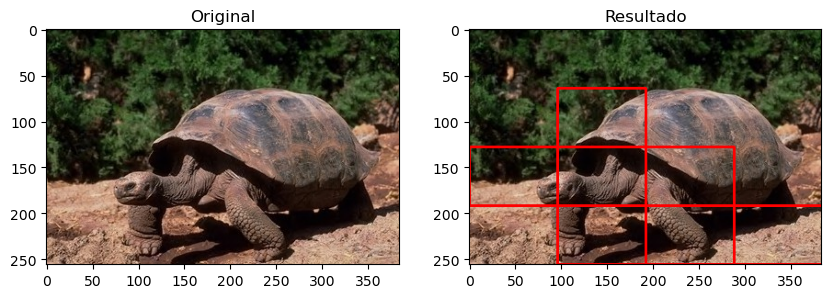

Región 5 con inconsistencia de iluminación
Región 6 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación


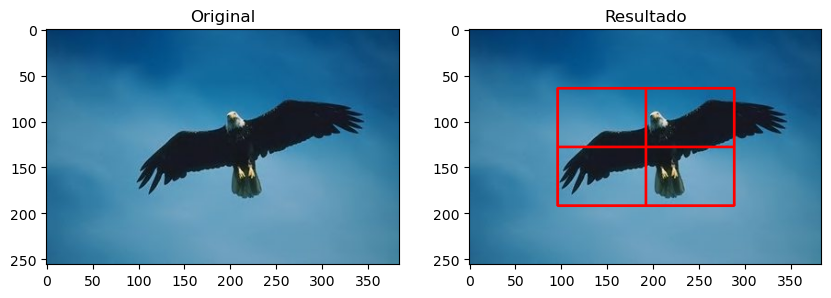

Región 5 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 11 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación
Región 15 con inconsistencia de iluminación


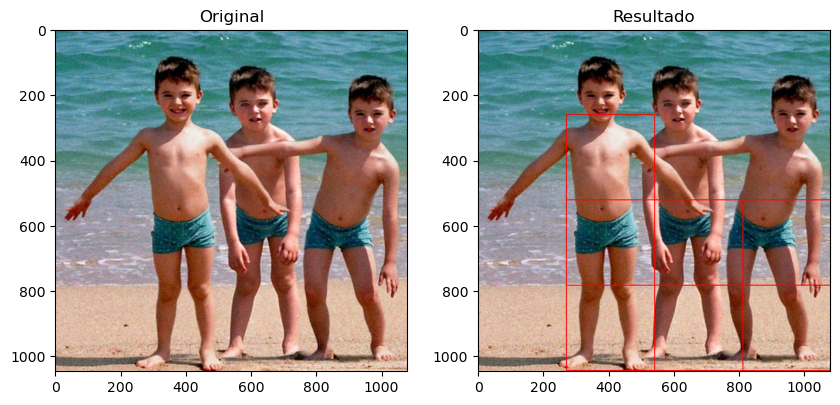

Región 5 con inconsistencia de iluminación
Región 8 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación


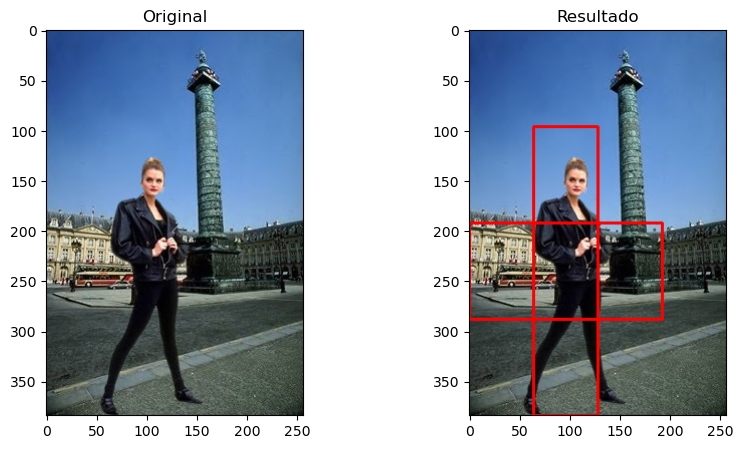

Región 9 con inconsistencia de iluminación


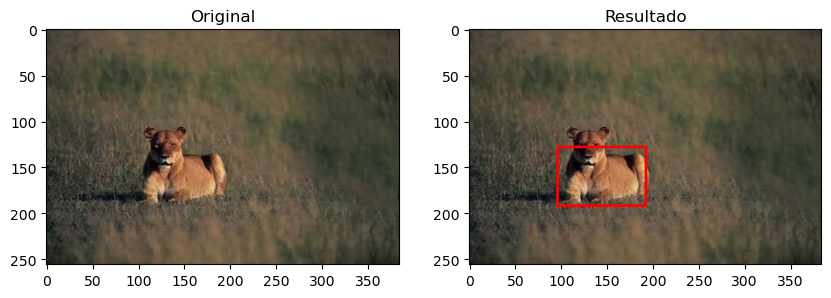

Región 1 con inconsistencia de iluminación
Región 2 con inconsistencia de iluminación
Región 5 con inconsistencia de iluminación
Región 6 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 11 con inconsistencia de iluminación


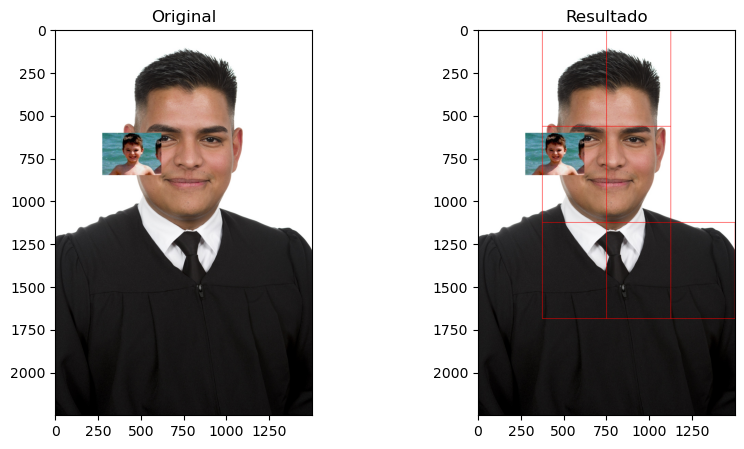

Región 4 con inconsistencia de iluminación
Región 5 con inconsistencia de iluminación
Región 6 con inconsistencia de iluminación
Región 7 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación


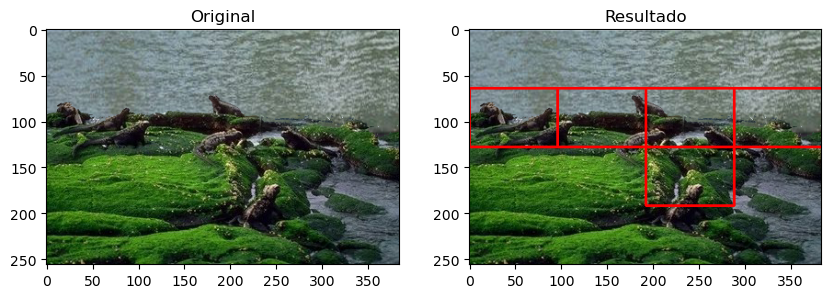

Región 4 con inconsistencia de iluminación
Región 5 con inconsistencia de iluminación
Región 6 con inconsistencia de iluminación
Región 8 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación


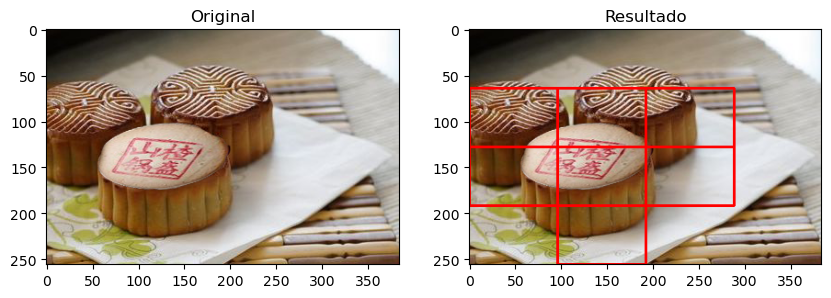

Región 0 con inconsistencia de iluminación
Región 1 con inconsistencia de iluminación
Región 3 con inconsistencia de iluminación
Región 4 con inconsistencia de iluminación
Región 8 con inconsistencia de iluminación
Región 15 con inconsistencia de iluminación


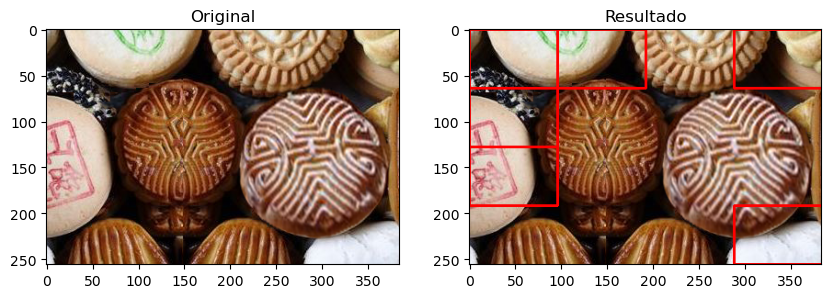

Región 5 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 12 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación


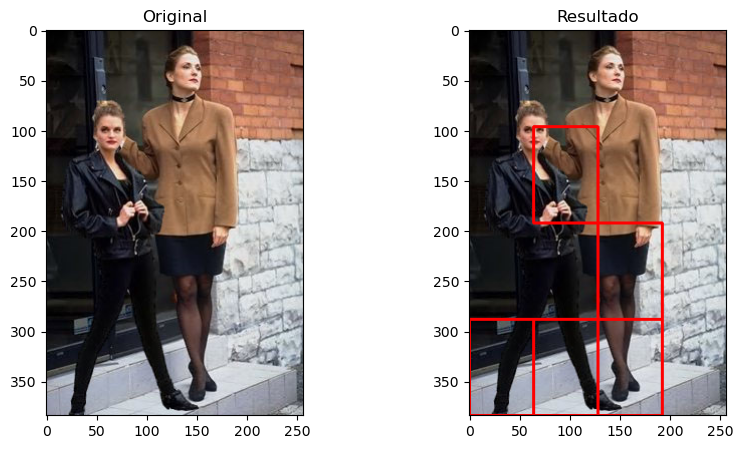

Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 12 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación
Región 15 con inconsistencia de iluminación


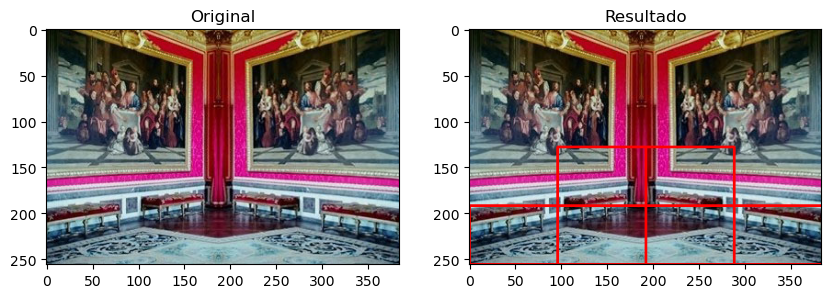

Región 8 con inconsistencia de iluminación
Región 11 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación


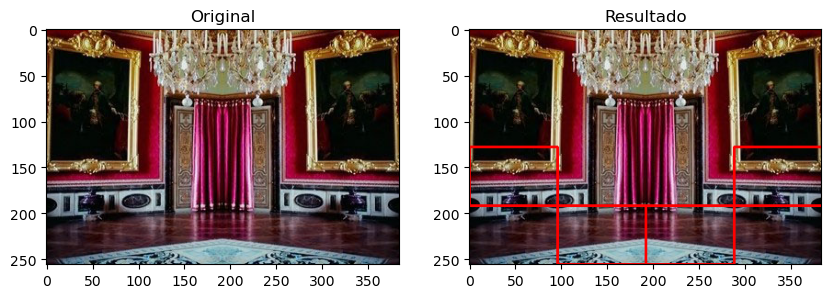

Región 1 con inconsistencia de iluminación
Región 5 con inconsistencia de iluminación
Región 6 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación
Región 11 con inconsistencia de iluminación


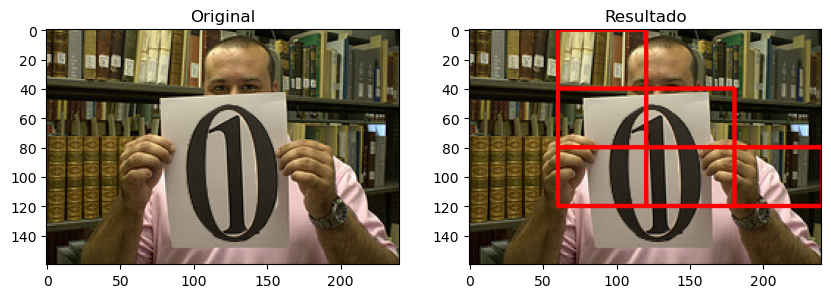

Región 4 con inconsistencia de iluminación
Región 8 con inconsistencia de iluminación
Región 9 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación


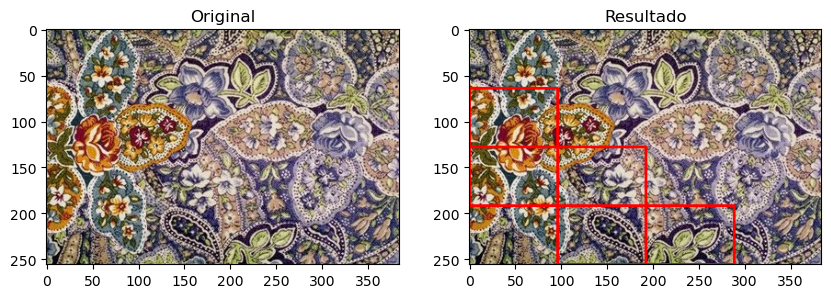

Región 3 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación


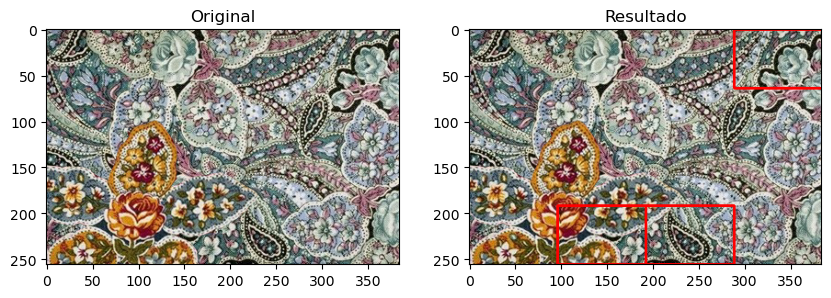

Región 0 con inconsistencia de iluminación
Región 1 con inconsistencia de iluminación
Región 2 con inconsistencia de iluminación
Región 3 con inconsistencia de iluminación
Región 4 con inconsistencia de iluminación
Región 10 con inconsistencia de iluminación


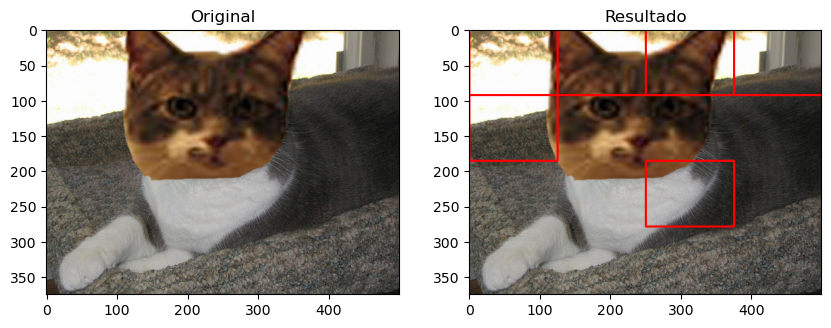

Región 4 con inconsistencia de iluminación
Región 5 con inconsistencia de iluminación
Región 8 con inconsistencia de iluminación
Región 11 con inconsistencia de iluminación
Región 13 con inconsistencia de iluminación
Región 14 con inconsistencia de iluminación


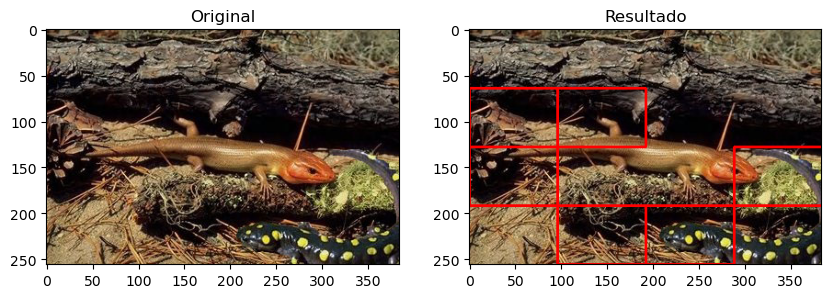

In [8]:
def lighting_inconsistency_detection(image_path, num_regions=4, threshold=150,vertical=True):
    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, 0)

    img_original = cv2.imread(image_path)
    # Dividir la imagen utilizando ventanas deslizantes, por ejemplo dividir la imagen en 8 cuadros distintos de igual tamaño (8x8)
    regions = []
    height, width = image.shape
    region_height = int(height / num_regions)
    region_width = int(width / num_regions)

    for i in range(num_regions):
        for j in range(num_regions):
            region = image[i * region_height:(i + 1) * region_height, j * region_width:(j + 1) * region_width]
            regions.append(region)

    # Calcular la varianza de cada región
    variances = []
    for region in regions:
        variances.append(np.var(region))

    # Calcular la varianza promedio
    mean_variance = np.mean(variances)

    # Detectar las regiones con inconsistencias de iluminación
    inconsistent_regions = []
    for i, variance in enumerate(variances):
        if variance > mean_variance + threshold:
            inconsistent_regions.append(i)

    # Visualizar las regiones con inconsistencias de iluminación
    for i, region in enumerate(regions):
        if i in inconsistent_regions:
            print("Región {} con inconsistencia de iluminación".format(i))
            # Obtener las posiciones de la región en la imagen original
            x = (i % num_regions) * region_width
            y = int(i / num_regions) * region_height
            # Dibujar un rectángulo en la imagen original
            cv2.rectangle(img_original, (x, y), (x + region_width, y + region_height), (0, 0, 255), 2)

    # Visualizar la imagen original
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    #mostrar la imagen original en color
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Original")
    plt.subplot(1, 2, 2)
    #mostrar la imagen original con los rectángulos
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    plt.imshow(img_original)
    plt.title("Resultado")
    plt.show()



    return inconsistent_regions, regions

test_images_path = '../tests/*.*'

for file_path in glob.glob(test_images_path):
    inconsistent_regions, regions = lighting_inconsistency_detection(file_path, num_regions=4, threshold=300)

